In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpltern

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
def kl_div_dirichlet(alpha_1, alpha_2):
    return sp.special.gammaln(np.sum(alpha_1,axis=1)) - np.sum(sp.special.gammaln(alpha_1),axis=1) - sp.special.gammaln(np.sum(alpha_2, axis=1)) + np.sum(sp.special.gammaln(alpha_2),axis=1) + np.sum((alpha_1-alpha_2)*(sp.special.digamma(alpha_1)-sp.special.digamma(np.sum(alpha_1, axis=1))[:,np.newaxis]),axis=1)

def sym_kl_div_dirichlet(alpha_1, alpha_2):
    return 0.5*(kl_div_dirichlet(alpha_1, alpha_2) + kl_div_dirichlet(alpha_2, alpha_1))

In [4]:
n_dims = 3
num_users = 200
prior = 1.0
temperature = 0.5
num_samples = 100

In [5]:
num_days = np.random.randint(200, 365, (num_users,1))
alphas = sp.special.softmax(np.random.randn(num_users, n_dims)/temperature, axis=1)*num_days + prior
dir_dists = [sp.stats.dirichlet(alphas[user_no]) for user_no in range(num_users)]
samples_dir = np.array([dir_dist.rvs(num_samples) for dir_dist in dir_dists])
means_dir = [dir_dist.mean() for dir_dist in dir_dists]

In [6]:
# distances = np.zeros((num_users, num_users))
# for user_no_1 in range(num_users):
#     for user_no_2 in range(num_users):
#         distances[user_no_1, user_no_2] = sym_kl_div_dirichlet(alphas[user_no_1], alphas[user_no_2])

AxisError: axis 1 is out of bounds for array of dimension 1

In [7]:
distances = sym_kl_div_dirichlet(alphas[:,:,None], alphas.T[None,:,:])

In [8]:
from sklearn.cluster import AgglomerativeClustering

num_stereotypes = 25

clustering = AgglomerativeClustering(n_clusters=num_stereotypes, metric="precomputed", linkage="average", compute_distances=True).fit(distances)
labels = clustering.labels_

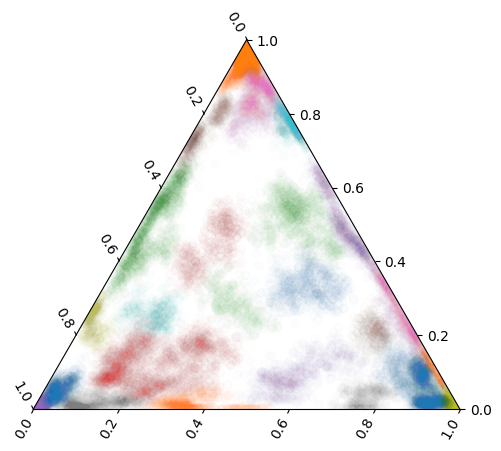

In [9]:
ax = plt.subplot(projection='ternary', ternary_sum=1)

for user_no in range(num_users):
    ax.scatter(samples_dir[user_no][:,0], samples_dir[user_no][:,1], samples_dir[user_no][:,2], label=f"User {user_no}", alpha=0.01, color=f"C{labels[user_no]}")

In [10]:
stereotypes = np.zeros((num_stereotypes, n_dims))
for stereotype_no in range(num_stereotypes):
    stereotype = np.mean(alphas[labels==stereotype_no], axis=0)
    stereotypes[stereotype_no] = stereotype

In [11]:
samples_stereotypes_dir = np.array([sp.stats.dirichlet(stereotype).rvs(num_samples) for stereotype in stereotypes])
means_stereotypes_dir = [stereotype for stereotype in stereotypes]

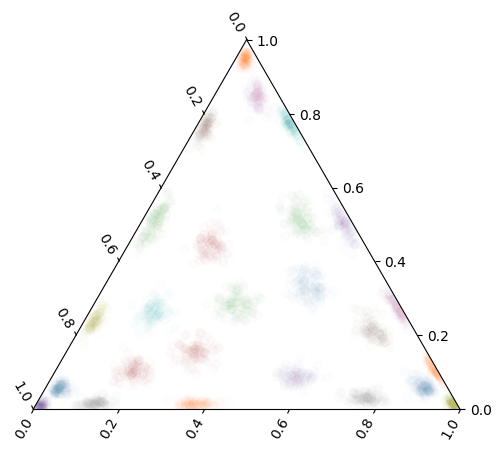

In [12]:
ax = plt.subplot(projection='ternary', ternary_sum=1)

for stereotype_no in range(num_stereotypes):
    ax.scatter(samples_stereotypes_dir[stereotype_no][:,0], samples_stereotypes_dir[stereotype_no][:,1], samples_stereotypes_dir[stereotype_no][:,2], label=f"Stereotype {stereotype_no}", alpha=0.01, color=f"C{stereotype_no}")

In [13]:
stereo_distances = sym_kl_div_dirichlet(stereotypes[:,:,None], stereotypes.T[None,:,:])

In [14]:
## find closest neighbor
closest_neighbor_str = np.zeros(num_stereotypes, dtype=int)
closest_distances_str = np.zeros(num_stereotypes)
stereo_distances_ = stereo_distances.copy()
for stereotype in range(num_stereotypes):
    stereo_distances_[stereotype, stereotype] = np.nan
    closest_neighbor_str[stereotype] = np.nanargmin(stereo_distances_[stereotype])
    closest_distances_str[stereotype] = stereo_distances_[stereotype, closest_neighbor_str[stereotype]]

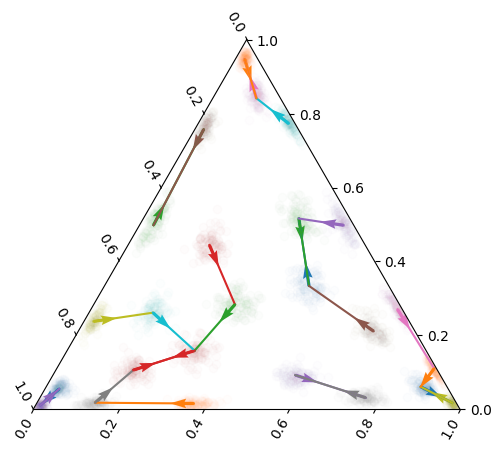

In [15]:
ax = plt.subplot(projection='ternary', ternary_sum=1)

for stereotype_no in range(num_stereotypes):
    ax.scatter(samples_stereotypes_dir[stereotype_no][:,0], samples_stereotypes_dir[stereotype_no][:,1], samples_stereotypes_dir[stereotype_no][:,2], label=f"Stereotype {stereotype_no}", alpha=0.01, color=f"C{stereotype_no}")
    ax.quiver(means_stereotypes_dir[stereotype_no][0], means_stereotypes_dir[stereotype_no][1], means_stereotypes_dir[stereotype_no][2], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][0]-means_stereotypes_dir[stereotype_no][0], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][1]-means_stereotypes_dir[stereotype_no][1], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][2]-means_stereotypes_dir[stereotype_no][2], color=f"C{stereotype_no}")
    ax.plot([means_stereotypes_dir[stereotype_no][0], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][0]], [means_stereotypes_dir[stereotype_no][1], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][1]], [means_stereotypes_dir[stereotype_no][2], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][2]], color=f"C{stereotype_no}")

In [16]:
eps = 0.05
interpolation_degrees = (.5-eps) * ( (np.log(closest_distances_str) - np.min(np.log(closest_distances_str))) / (np.max(np.log(closest_distances_str)) - np.min(np.log(closest_distances_str)))) + (eps)
stereotype_interpolates = np.zeros((num_stereotypes, n_dims))
for stereotype in range(num_stereotypes):
    stereotype_interpolates[stereotype] = (1-interpolation_degrees[stereotype])*stereotypes[stereotype] + interpolation_degrees[stereotype]*stereotypes[closest_neighbor_str[stereotype]]

In [17]:
samples_interpolates_dir = np.array([sp.stats.dirichlet(stereotype_interpolates[stereotype]).rvs(num_samples) for stereotype in range(num_stereotypes)])

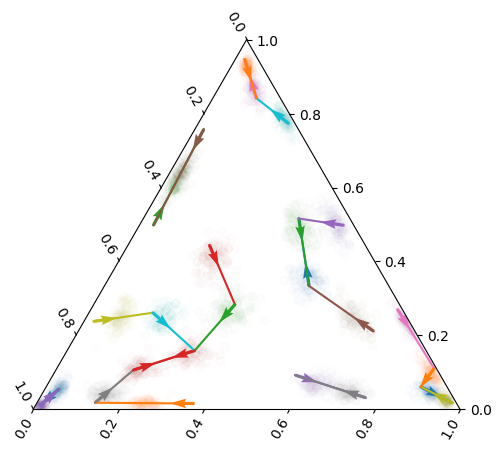

In [18]:
ax = plt.subplot(projection='ternary', ternary_sum=1)

for stereotype_no in range(num_stereotypes):
    ax.scatter(samples_interpolates_dir[stereotype_no][:,0], samples_interpolates_dir[stereotype_no][:,1], samples_interpolates_dir[stereotype_no][:,2], label=f"Stereotype {stereotype_no}", alpha=0.01, color=f"C{stereotype_no}")
    ax.quiver(means_stereotypes_dir[stereotype_no][0], means_stereotypes_dir[stereotype_no][1], means_stereotypes_dir[stereotype_no][2], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][0]-means_stereotypes_dir[stereotype_no][0], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][1]-means_stereotypes_dir[stereotype_no][1], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][2]-means_stereotypes_dir[stereotype_no][2], color=f"C{stereotype_no}")
    ax.plot([means_stereotypes_dir[stereotype_no][0], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][0]], [means_stereotypes_dir[stereotype_no][1], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][1]], [means_stereotypes_dir[stereotype_no][2], means_stereotypes_dir[closest_neighbor_str[stereotype_no]][2]], color=f"C{stereotype_no}")

# plt.legend()


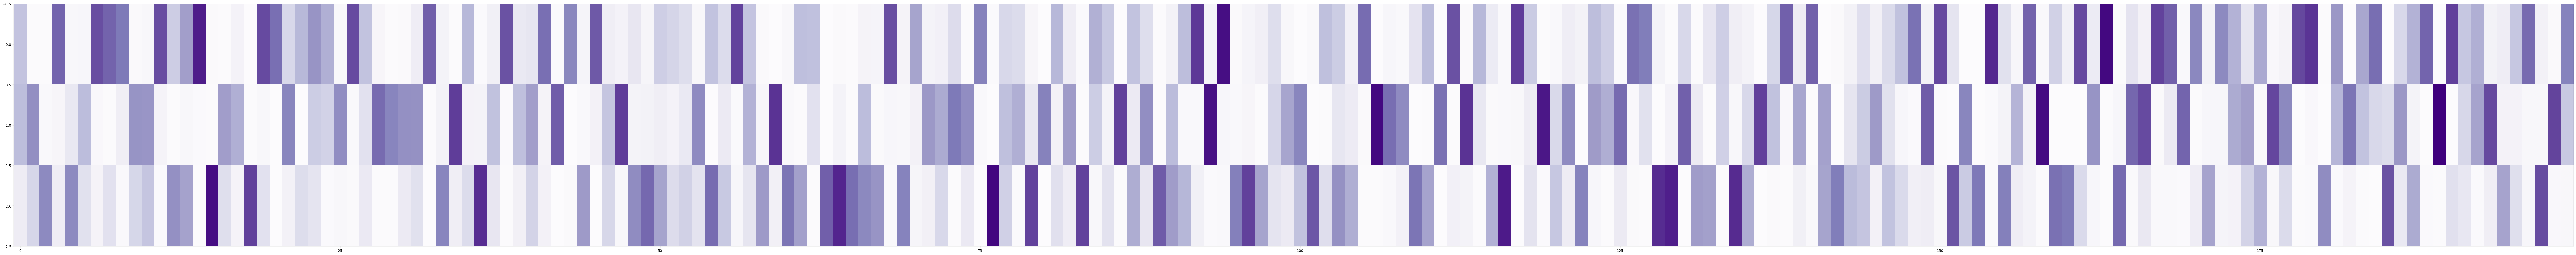

In [19]:
fig, ax = plt.subplots(figsize=(100,10))
fig.tight_layout()

plt.imshow(alphas.T, aspect='auto', interpolation='nearest', cmap='Purples')

In [20]:
users_stereotyped = np.zeros((num_users, n_dims))
for user_no in range(num_users):
    users_stereotyped[user_no] = stereotypes[labels[user_no]]

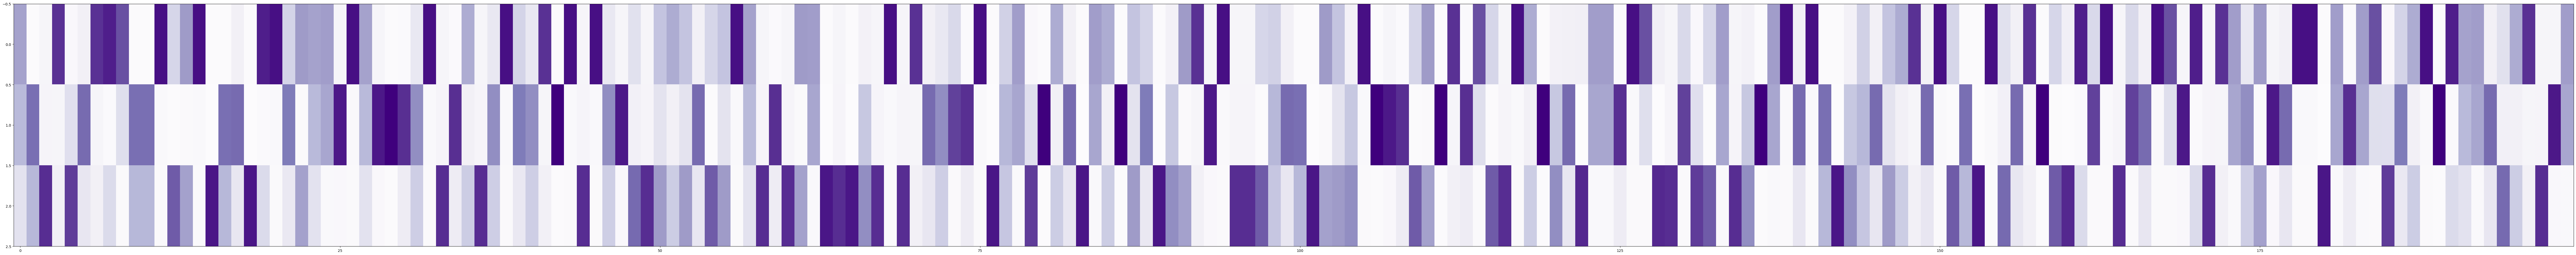

In [21]:
fig, ax = plt.subplots(figsize=(100,10))
fig.tight_layout()

plt.imshow(users_stereotyped.T, aspect='auto', interpolation='nearest', cmap='Purples')

In [22]:
users_stereotyped_interpolated = np.zeros((num_users, n_dims))
for user_no in range(num_users):
    users_stereotyped_interpolated[user_no] = stereotype_interpolates[labels[user_no]]

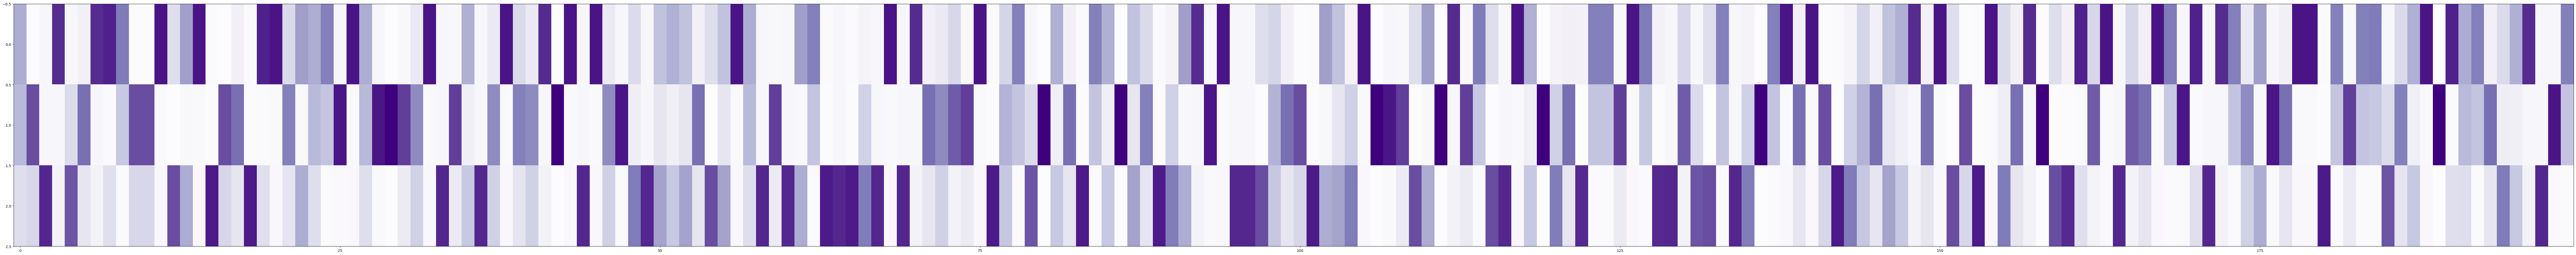

In [23]:
fig, ax = plt.subplots(figsize=(100,10))
fig.tight_layout()

plt.imshow(users_stereotyped_interpolated.T, aspect='auto', interpolation='nearest', cmap='Purples')